# ASSIGNMENT

In this notebook, using the **Seattle Bicycle Weather** dataset, I will make these visualizations:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

In [1]:
# Import libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

## Prepare Data and Initial Model



In [2]:
def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily


In [3]:
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    ""
    return X_train, X_test, y_train, y_test

In [4]:
def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

def wrangle(X):
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    # DS1 DH
    X['PRCP_yesterday'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_squared'] = X['TMIN'] **2
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    # DS3 JD
    X['light_rain'] = (X['PRCP'] > 0) & (X['PRCP'] < 0.10)
    X['moderate_rain'] = (X['PRCP'] >= 0.1) & (X['PRCP'] < 0.30)
    X['heavy_rain'] = (X['PRCP'] >= 0.30)
    X['weekend_day'] = (X['Sat'] == 1) | (X['Sun'] == 1)
    
    #snow and snwd is in 1/10 mm; convert to inches
    X['SNOW'] /= 254
    X['SNWD'] /= 254
    
    #create interaction terms
    X['PRCP_TMXAX'] = X['PRCP'] * X['TMAX']
    X['PRCP_TMIN'] = X['PRCP'] * X['TMIN']
    X['PRCP_Temp_(C)'] = X['PRCP'] * X ['Temp (C)']
    

    return X


In [5]:
data = load()

In [27]:
# load and wrangle

df = wrangle(data)
X_train, X_test, y_train, y_test = split(df)

In [28]:
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1,5)
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions = param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score=True,
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   10.3s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6b480feb70>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6b480feb00>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [29]:
print('Mean Absolute Error with CV ')
print(f'Predictions are off by {-search.best_score_} bicyclists per day, on average')

best = search.best_estimator_

y_pred = best.predict(X_test.values)
print(f'Test Predictions are off by {mean_absolute_error(y_test, y_pred)} bicyclists per day, on average')

Mean Absolute Error with CV 
Predictions are off by 265.8202038306437 bicyclists per day, on average
Test Predictions are off by 229.39616943359374 bicyclists per day, on average


## Feature Importances

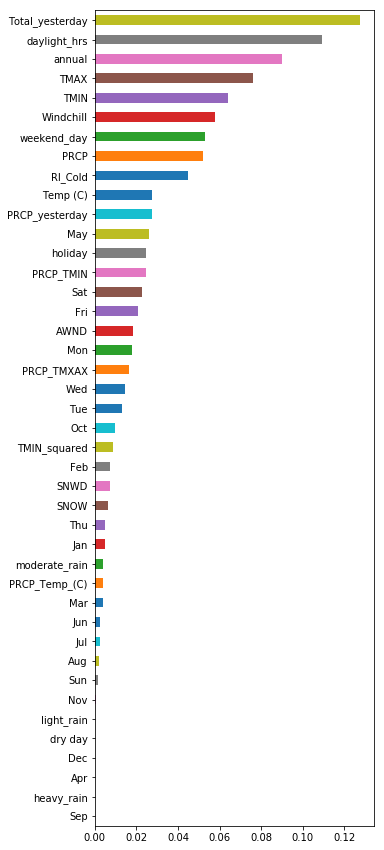

In [30]:
# this plots our models default importances 
n = len(X_train.columns)

size= (5,15)

importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values()[-n:]

plt.figure(figsize=size)
top_n.plot.barh();

## Permutation Importances


In [31]:
import eli5
from eli5.sklearn import PermutationImportance

In [32]:
permuter = PermutationImportance(best, scoring='neg_mean_absolute_error', cv='prefit',
                                n_iter=10, random_state=42)
permuter.fit(X_test, y_test)

PermutationImportance(cv='prefit',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=495,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
           n_iter=10, random_state=42, refit=True,
           scoring='neg_mean_absolute_error')

In [33]:
feature_names = X_test.columns.tolist()

eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
616.8545 ± 95.9090,weekend_day
98.0979 ± 38.9224,Total_yesterday
95.4274 ± 24.3771,TMAX
57.5296 ± 25.4705,PRCP
46.5783 ± 21.0090,Fri
30.0292 ± 13.8079,Tue
29.6315 ± 9.3737,holiday
27.4834 ± 12.4478,TMIN
26.7817 ± 10.2552,Sat
16.7522 ± 16.5919,Mon


In [13]:
# we'll use this for feature selection
print('Shape before removing features:', X_train.shape)

Shape before removing features: (963, 42)


In [35]:
mask = permuter.feature_importances_ > 0

important_features = X_train.columns[mask]

X_train = X_train[important_features]
X_test = X_test[important_features]


print('Shape after removing features: ', X_train.shape)

Shape after removing features:  (963, 23)


In [34]:
X_train.head()

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,...,Oct,Nov,Dec,light_rain,moderate_rain,heavy_rain,weekend_day,PRCP_TMXAX,PRCP_TMIN,PRCP_Temp_(C)
2012-10-04,0.0,0.0,0.0,18.9,8.3,65,3521.0,0.0,0.0,0.0,...,1.0,0.0,0.0,False,False,False,False,0.0,0.0,0.0
2012-10-05,0.0,0.0,0.0,21.7,8.9,57,3475.0,0.0,0.0,0.0,...,1.0,0.0,0.0,False,False,False,False,0.0,0.0,0.0
2012-10-06,0.0,0.0,0.0,23.9,7.8,51,3148.0,0.0,0.0,0.0,...,1.0,0.0,0.0,False,False,False,True,0.0,0.0,0.0
2012-10-07,0.0,0.0,0.0,23.9,7.8,13,2006.0,0.0,0.0,0.0,...,1.0,0.0,0.0,False,False,False,True,0.0,0.0,0.0
2012-10-08,0.0,0.0,0.0,21.1,7.8,19,2142.0,1.0,0.0,0.0,...,1.0,0.0,0.0,False,False,False,False,0.0,0.0,0.0


In [36]:
X_test.head()

,PRCP,TMAX,TMIN,Total_yesterday,Mon,Tue,Wed,Fri,Sat,holiday,...,Windchill,Rl_Cold,May,Jun,Jul,Aug,weekend_day,PRCP_TMXAX,PRCP_TMIN,PRCP_Temp_(C)
2015-05-25,0.0,15.6,11.1,1776.0,1.0,0.0,0.0,0.0,0.0,1.0,...,18.657733,2.984593,1.0,0.0,0.0,0.0,False,0.0,0.0,0.0
2015-05-26,0.0,21.7,11.7,1737.0,0.0,1.0,0.0,0.0,0.0,0.0,...,26.742639,1.842978,1.0,0.0,0.0,0.0,False,0.0,0.0,0.0
2015-05-27,0.0,24.4,11.7,4254.0,0.0,0.0,1.0,0.0,0.0,0.0,...,30.303846,1.214530,1.0,0.0,0.0,0.0,False,0.0,0.0,0.0
2015-05-28,0.0,27.8,12.2,4771.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.730525,1.816375,1.0,0.0,0.0,0.0,False,0.0,0.0,0.0
2015-05-29,0.0,26.1,12.8,5142.0,0.0,0.0,0.0,1.0,0.0,0.0,...,30.469309,2.522606,1.0,0.0,0.0,0.0,False,0.0,0.0,0.0


In [37]:
X_test.columns

Index(['PRCP', 'TMAX', 'TMIN', 'Total_yesterday', 'Mon', 'Tue', 'Wed', 'Fri',
       'Sat', 'holiday', 'daylight_hrs', 'Temp (C)', 'PRCP_yesterday',
       'Windchill', 'Rl_Cold', 'May', 'Jun', 'Jul', 'Aug', 'weekend_day',
       'PRCP_TMXAX', 'PRCP_TMIN', 'PRCP_Temp_(C)'],
      dtype='object')

In [44]:
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1,5)
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions = param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score=True,
    random_state=42
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1958s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    5.1s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6b33f297b8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6b33f29588>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [45]:
X_test.columns

Index(['PRCP', 'TMAX', 'TMIN', 'Total_yesterday', 'Mon', 'Tue', 'Wed', 'Fri',
       'Sat', 'holiday', 'daylight_hrs', 'Temp (C)', 'PRCP_yesterday',
       'Windchill', 'Rl_Cold', 'May', 'Jun', 'Jul', 'Aug', 'weekend_day',
       'PRCP_TMXAX', 'PRCP_TMIN', 'PRCP_Temp_(C)'],
      dtype='object')

In [50]:
print('Mean Absolute Error with CV on only important features')
print(f'Predictions are off by {-search.best_score_} bicyclists per day, on average')

best = search.best_estimator_

y_pred = best.predict(X_test)

print(f'Test Predictions are off by {mean_absolute_error(y_test, y_pred)} bicyclists per day, on average')

Mean Absolute Error with CV on only important features
Predictions are off by 270.5941130993646 bicyclists per day, on average
Test Predictions are off by 269.43383239746095 bicyclists per day, on average


Well this did not improve our score it seems. :)

## Partial Dependence Plot

In [51]:
X_train.columns.tolist()

['PRCP',
 'TMAX',
 'TMIN',
 'Total_yesterday',
 'Mon',
 'Tue',
 'Wed',
 'Fri',
 'Sat',
 'holiday',
 'daylight_hrs',
 'Temp (C)',
 'PRCP_yesterday',
 'Windchill',
 'Rl_Cold',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'weekend_day',
 'PRCP_TMXAX',
 'PRCP_TMIN',
 'PRCP_Temp_(C)']

In [52]:
assert(X_test.columns == X_train.columns).all()

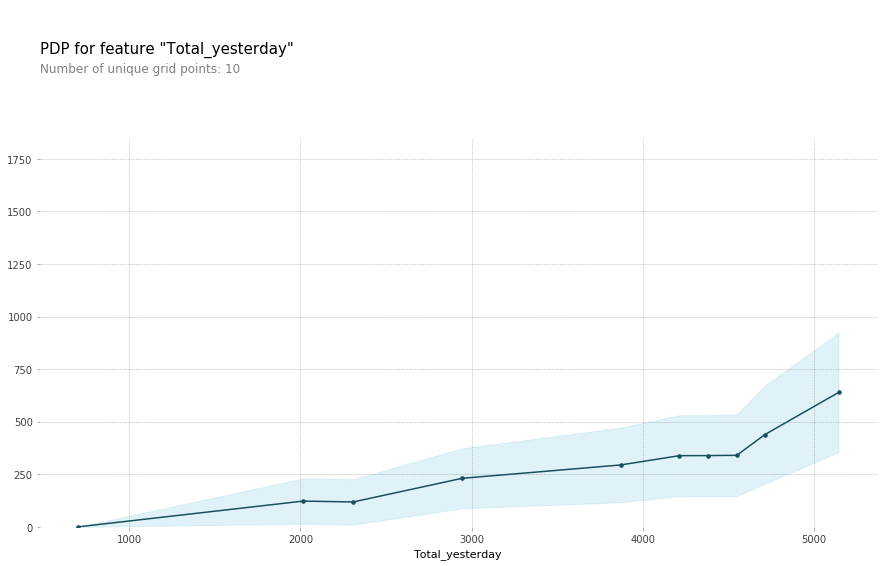

In [53]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Total_yesterday'

isolated = pdp_isolate(
    model = best,
    dataset = X_test,
    model_features = X_test.columns,
    feature = feature
)

pdp_plot(isolated, feature_name = feature);

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6b33edb7b8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6b33bd16d8>})

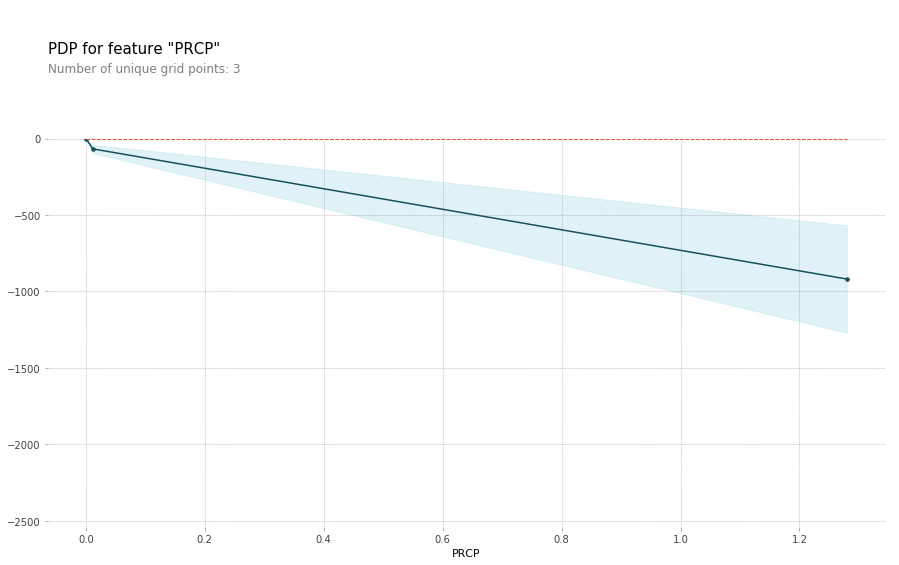

In [54]:
from pdpbox.pdp import pdp_interact, pdp_isolate, pdp_plot, pdp_interact_plot

feature = 'PRCP'

isolated = pdp_isolate(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    feature = feature
)

pdp_plot(isolated, feature_name=feature)

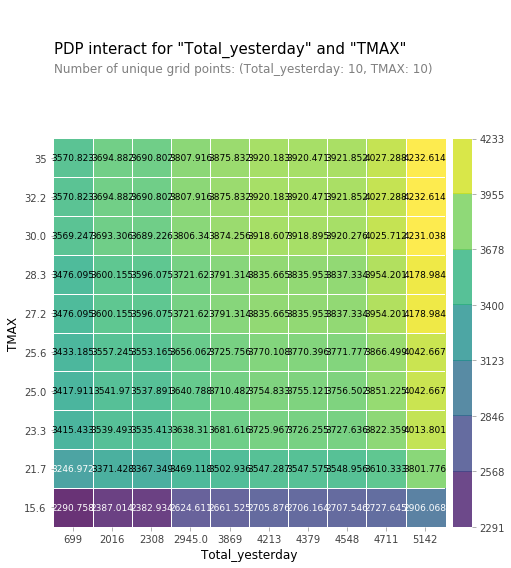

In [56]:
features = ['Total_yesterday', 'TMAX']

interaction = pdp_interact(
    model=best,
    dataset=X_test,
    model_features=X_test.columns.tolist(),
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

## Shapley Values

In [63]:
best.predict_proba(X_test)

AttributeError: 'XGBRegressor' object has no attribute 'predict_proba'

In [65]:
y_pred = best.predict(X_test)


preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

preds['abs_error'] = abs(preds['y_test'] - preds['y_pred'])

preds.head()

,y_test,y_pred,abs_error
2015-05-25,1737.0,2259.536133,522.536133
2015-05-26,4254.0,4418.058594,164.058594
2015-05-27,4771.0,4838.770996,67.770996
2015-05-28,5142.0,4824.912109,317.087891
2015-05-29,4548.0,4881.972168,333.972168


### Most and Least Accurate Predictions

In [73]:
most_acc =preds.sort_values('abs_error')[:5] 
least_acc = preds.sort_values('abs_error')[-5:]

In [74]:
most_acc

,y_test,y_pred,abs_error
2015-08-21,3606.0,3600.000732,5.999268
2015-06-17,4711.0,4703.977051,7.022949
2015-07-15,4686.0,4671.411133,14.588867
2015-06-11,4719.0,4701.700684,17.299316
2015-07-28,4715.0,4694.797363,20.202637


In [91]:
# shap for most accurate
import shap
shap.initjs()

data = X_test[X_test.index == '2015-08-21']

explainer= shap.TreeExplainer(best)

shap_values = explainer.shap_values(data)

shap.force_plot(explainer.expected_value, shap_values, data)


In [92]:
least_acc

,y_test,y_pred,abs_error
2015-08-31,2823.0,3482.985352,659.985352
2015-07-25,1384.0,2169.044678,785.044678
2015-07-03,2313.0,3222.000732,909.000732
2015-08-12,4403.0,3492.499512,910.500488
2015-08-28,2653.0,3717.476318,1064.476318


In [87]:
# shap for least accurate
shap.initjs()

data = X_test[X_test.index == least_acc.index[0]]

explainer= shap.TreeExplainer(best)

shap_values = explainer.shap_values(data)

shap.force_plot(explainer.expected_value, shap_values, data)